In [1]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)

In [3]:
main_df['dataset_type'] = main_df.apply((lambda row : row['dataset_type'] if row['dataset'] != 'standardTesting' else 'oclassical'), axis = 1)

## Aggregate Stats

In [4]:
main_df['kstest_stat_overall_best'] = np.minimum.reduce([main_df['kstest_stat_best'], main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])
temp = main_df[main_df['beat_all_priors'] == 0].copy()
n = len(main_df)

c1, c0 = main_df['beat_all_priors'].value_counts()
print("% Beats All Other Priors:", c1 / n * 100, ",", c1, "/", n)
trivial_fails, _, _, _, _ = temp['failure_category'].value_counts()
print("Given that OurPrior is Worse, % Trivial Failures:", trivial_fails / n * 100, ",", trivial_fails, "/", n)

temp = temp[temp['failure_category'] != 'trivial_failure']
print("Given that OurPrior is Worse, Maximum difference between OurPrior and Best:", max(np.abs(temp['kstest_stat_overall_best'] - temp['kstest_stat_best'])))

% Beats All Other Priors: 91.66666666666666 , 1056 / 1152
Given that OurPrior is Worse, % Trivial Failures: 7.465277777777778 , 86 / 1152
Given that OurPrior is Worse, Maximum difference between OurPrior and Best: 0.0035451361585638


In [5]:
practical, trivial, actual, border, interesting = main_df['failure_category'].sort_values().value_counts()
print("Actually Passing:", (practical) / n)
print("Practically Passing:", (practical) / n)
print("Passing Overall:", (practical + trivial) / n)
print("Passing Overall (borderline):", (practical + trivial + border) / n)


Actually Passing: 0.5477430555555556
Practically Passing: 0.5477430555555556
Passing Overall: 0.7786458333333334
Passing Overall (borderline): 0.8298611111111112


In [6]:
main_df = main_df[main_df['total_samples'].iloc[:, 0] > 100]
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r']
main_df = main_df#[(main_df['dataset'] != 'standardTesting')]

In [7]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

main_df['dataset'] = (main_df['dataset'] + main_df['subset']).replace(name_mapping)

In [8]:
main_df['hull_eta_lower'] = main_df['hull_beta_lower']
main_df["n_pval_0.05"]

1          634.0
2         6337.0
3       148388.0
4       243324.0
5       198143.0
          ...   
1147     11664.0
1148      8748.0
1149     33214.0
1150     20736.0
1151      3456.0
Name: n_pval_0.05, Length: 1130, dtype: float64

In [9]:
granularity1 = ['transform', 'dataset_type', 'dataset']
final_cols =  ['median_total_samples', 'kstest_stat_best', 'statistically_pass', 'practically_pass', 'intersect_roi']  #, 'uses_practical_threshold', 'intersect_roi', 'hull_r_lower_ci95', 'hull_r_upper_ci95', 'hull_beta_lower_ci95', 'hull_beta_upper_ci95']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')

summary_df = (temp.groupby(granularity1)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df["kstest_stat_best"] = temp.groupby(granularity1)['kstest_stat_best'].median(numeric_only=True)
# summary_df["kstest_stat_best_std"] = temp.groupby(granularity1)['kstest_stat_best'].std(numeric_only=True)
# summary_df["kstest_stat_best"] = (summary_df["kstest_stat_best_median"].round(4).astype(str) + " (" + (2*summary_df["kstest_stat_best_std"]).round(4).astype(str) + ")")
summary_df["median_total_samples"] = temp.groupby(granularity1)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, exp_digits=1, precision=1))

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df[f'{col}_ci95'] = temp.groupby(granularity1)[col].apply(lambda x:  [np.round(x, 2) for x in np.percentile(x, [2.5, 97.5])])
summary_df = summary_df[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df

median_total_samples  \
transform dataset_type   dataset                                          
fourier   remote sensing agriVision                              2.6e+6   
                         pastis                                  2.6e+5   
                         spaceNet                                1.8e+6   
learned   natural        coco (indoor)                            2.e+8   
                         coco (outdoor)                           2.e+8   
                         segmentAnything                         7.9e+8   
          oclassical     standardTesting                         7.1e+6   
          remote sensing agriVision                              7.9e+8   
                         pastis                                  4.9e+7   
                         spaceNet                                4.8e+8   
wavelet   medical        syntheticMRI2D (axial)                  4.2e+6   
                         syntheticMRI2D (coronal)                3.7e+6   
                         syntheticMRI2D (sagittal)               2.4e+6   
                         syntheticMRI3D                          1.6e+6   
          natural        coco (indoor)                           2.6e+5   
                         coco (outdoor)                          3.9e+5   
                         segmentAnything                         1.8e+6   
          oclassical     standardTesting                         9.2e+3   
          remote sensing agriVision                              1.7e+6   
                         pastis                                  1.5e+5   
                         spaceNet                                1.6e+6   

                                                    kstest_stat_best  \
transform dataset_type   dataset                                       
fourier   remote sensing agriVision                            0.005   
                         pastis                                0.002   
                         spaceNet                              0.005   
learned   natural        coco (indoor)                         0.009   
                         coco (outdoor)                        0.010   
                         segmentAnything                       0.005   
          oclassical     standardTesting                       0.014   
          remote sensing agriVision                            0.005   
                         pastis                                0.004   
                         spaceNet                              0.013   
wavelet   medical        syntheticMRI2D (axial)                0.007   
                         syntheticMRI2D (coronal)              0.004   
                         syntheticMRI2D (sagittal)             0.005   
                         syntheticMRI3D                        0.005   
          natural        coco (indoor)                         0.013   
                         coco (outdoor)                        0.011   
                         segmentAnything                       0.004   
          oclassical     standardTesting                       0.013   
          remote sensing agriVision                            0.005   
                         pastis                                0.004   
                         spaceNet                              0.012   

                                                    statistically_pass  \
transform dataset_type   dataset                                         
fourier   remote sensing agriVision                                2.3   
                         pastis                                   90.9   
                         spaceNet                                  0.0   
learned   natural        coco (indoor)                             0.0   
                         coco (outdoor)                            0.0   
                         segmentAnything                           0.0   
          oclassical     standardTesting                           0.0   
  

In [10]:
granularity2 = ['transform', 'dataset_type']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')
summary_df2 = (temp.groupby(granularity2)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df2["kstest_stat_best"] = temp.groupby(granularity2)['kstest_stat_best'].median(numeric_only=True)
summary_df2["kstest_stat_best_std"] = temp.groupby(granularity2)['kstest_stat_best'].std(numeric_only=True)
summary_df2["median_total_samples"] = temp.groupby(granularity2)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, 1))

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df2[f'{col}_ci95'] = temp.groupby(granularity2)[col].apply(lambda x:  [np.round(x, 1) for x in np.percentile(x, [2.5, 97.5])])


summary_df2 = summary_df2[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df, summary_df2]).reset_index()

summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'wavelet', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final.to_csv(os.path.join(plots_path, 'results_table.csv'))

In [11]:
summary_df_final

,transform,dataset_type,dataset,median_total_samples,kstest_stat_best,statistically_pass,practically_pass,intersect_roi
0,fourier,remote sensing,agriVision,2.6e+6,0.005,2.3,93.2,68.2
1,fourier,remote sensing,pastis,2.6e+5,0.002,90.9,9.1,100.0
2,fourier,remote sensing,spaceNet,1.8e+6,0.005,0.0,100.0,46.9
21,fourier,remote sensing,z_aggregate,5.5e+05,0.003,34.2,64.2,74.2
10,wavelet,medical,syntheticMRI2D (axial),4.2e+6,0.007,0.0,76.2,33.3
11,wavelet,medical,syntheticMRI2D (coronal),3.7e+6,0.004,9.5,71.4,57.1
12,wavelet,medical,syntheticMRI2D (sagittal),2.4e+6,0.005,0.0,81.0,76.2
13,wavelet,medical,syntheticMRI3D,1.6e+6,0.005,7.1,61.9,64.3
25,wavelet,medical,z_aggregate,2.9e+06,0.005,4.8,70.5,59.0
14,wavelet,natural,coco (indoor),2.6e+5,0.013,25.0,25.0,18.8


In [12]:
temp[['statistically_pass', 'practically_pass', 'intersect_roi', 'hull_area', 'total_samples']].mean(), main_df[['total_samples']].median()


(statistically_pass    1.495575e-01
 practically_pass      5.584071e-01
 intersect_roi         3.955752e-01
 hull_area             1.464403e+01
 total_samples         1.525233e+08
 total_samples         1.525233e+08
 dtype: float64,
 total_samples    7077888.0
 total_samples    7077888.0
 dtype: float64)

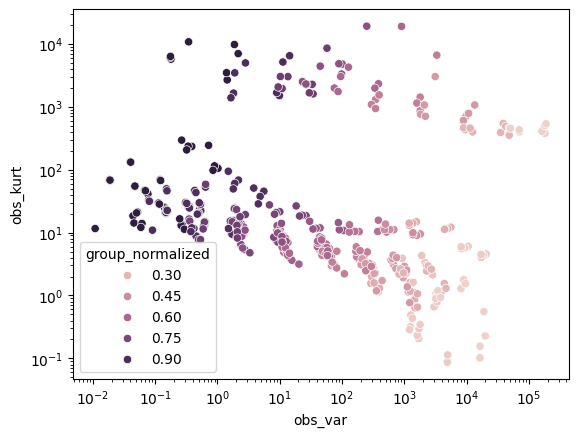

In [13]:
main_df['group_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['group'].transform(lambda x: x / x.max())
main_df['var_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_var'].transform(lambda x: x / x.max())
main_df['kurt_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_kurt'].transform(lambda x: x / x.max())
sns.scatterplot(data=main_df[main_df['transform'] != 'learned'], x='obs_var', y='obs_kurt', hue='group_normalized')
plt.xscale('log')
plt.yscale('log')


In [14]:
[stats.kstwo(n=10**i).isf(0.05) for i in range(3, 10)]

[0.042776500461245,
 0.013564202793681023,
 0.004293014618329405,
 0.0013579318555276864,
 0.0004294518283725128,
 0.00013580819714844155,
 4.294668320280901e-05]

In [15]:
main_df['n_pval_0.05']

1          634.0
2         6337.0
3       148388.0
4       243324.0
5       198143.0
          ...   
1147     11664.0
1148      8748.0
1149     33214.0
1150     20736.0
1151      3456.0
Name: n_pval_0.05, Length: 1130, dtype: float64

<Axes: >

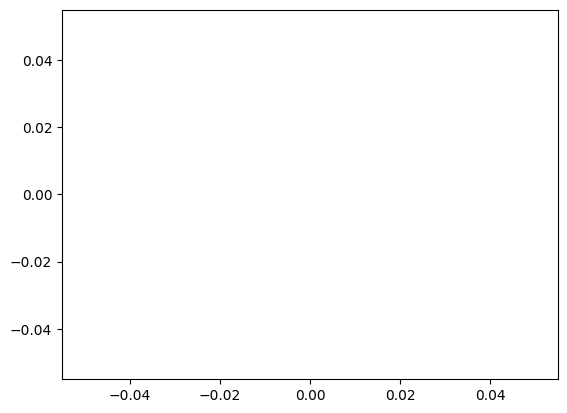

In [16]:
sns.histplot()